## Stock prices classification
Trying to predict future stock prices as a classification problem.

Using historical stock prices from Kaggle data set: https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

In Technical Analysis people compute different indicators from historical data, like moving averages, rate of change, etc.
Most indicators are only based on raw historical prices: open, close, low, high, volume.
Crafting and combining those indicators is not straighforward. Typical questions that arise are:
- Should I use simple moving average or exponential?
- 20 days moving average or 50?
- Is it important when the 20 days mov avg cross the 50 days or completely irrelevant?

The idea of this work is to let a neural network figure out which indicator should be created and how should be combined, without human intervention.
Each traning sample is composed of N historical dates. For each date we have multiple features: open, close, high, low, volume.
The target is to predict the percentage increment of a stock price in M days in the future.
Ex: using a 260 days historical window predict if 60 days in the future the price will be higher than 10%.
The historical window can be seen as a time-series of 5 features for each slot.
Each stock is splitted into multiple time-series. Training samples are a combination of time-series of multiple stocks all together.

There are multiple questions/variables that need to be defined to formulate this problem:
- Length of historical window: 1 month, 6 months, 1 year, 5 years?
- How far we should try to predict? 1 day, 1 month, 6 months, 2 years?
- What should be our target/label? Price greater than 10% (binary), or multi-label (>10%, >20%, >30%)?
- How to properly normalize features?
- Network architecture for time-series analysis: MLP, LSTM, Conv1D?
- Should we just use the raw date (open, close, etc) and let the network learn how to craft indicators or combine them?
- Or should we pre-generate many indicators as features (SMA10, SMA20, SMA50, etc) and only let the network learn how to combine them?

The following work is testing one possible formulation of this problem:
- Historical window of 1 year (260 business days)
- Predicting price increase in the next 60 days
- As a multi-label classification problem: price < -10% (10% loss or more), -10% < price < 10% (Flat), price > 10% (10% gain or more)
- 500 stocks and a few ETFs are picked with Kaggle dataset
- Samples are created with a rolling window of 5 days
- Using a Convolutional 1D network architecture

Please be advised that results are still far from being accurate enough for real investment.


In [1]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras
from keras import backend as K
import datetime as dt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
import os

RAND_SEED = 1
np.random.seed(RAND_SEED)
BASE_PATH = "/Users/matias.leone/Documents/Jupyter notebooks/"
STOCKS_BASE_PATH = BASE_PATH + "data/us_stocks/"

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Functions to load data

In [2]:
# Pick first N symbols
def generate_stock_list(path, max_symbols):
    all_stocks = np.array([f.split(".")[0] for f in os.listdir(path)])
    return all_stocks[np.random.choice(len(all_stocks), max_symbols)]

# Stocks and ETFs we'll be using
#STOCKS = ["tsla", "amzn", "fb", "aapl", "nvda", "goog", "nflx", "baba", "amd", "wmt", "bidu", "snap", "ibm", "f", "gm", "fcau", "twtr", "pzza"]
STOCKS = generate_stock_list(STOCKS_BASE_PATH + "Stocks/", 500) #Increase this number to have more samples
ETFS = ["spy", "qqq", "eem", "xlf", "gdx", "vxx", "ewz", "uso", "xlk", "hyg", "iyr", "tlt", "lqd", "agg", "ief", "veu", "fxi"]

def load_symbol_df(dir_path, file_name, out_array):
    full_path = dir_path + file_name
    if os.stat(full_path).st_size > 0: 
        df = pd.read_csv(full_path)
        columns = list(df.columns.values)
        symbol = file_name.split(".")[0]
        df["Symbol"] = symbol
        columns.insert(0, "Symbol")
        out_array.append(df[columns])
        
def load_data():
    print("Loading {} symbols".format(len(STOCKS) + len(ETFS)))
    all_files_df = []
    [load_symbol_df(STOCKS_BASE_PATH + "Stocks/", name + ".us.txt", all_files_df) for name in STOCKS]
    [load_symbol_df(STOCKS_BASE_PATH + "ETFs/", name + ".us.txt", all_files_df) for name in ETFS]
    merged_df = pd.concat(all_files_df)
    all_dates = merged_df["Date"].unique()
    print("Total symbols loaded: ", len(merged_df["Symbol"].unique()))
    print("Dates from: {}, to: {}, total: {}".format(all_dates.min(), all_dates.max(), len(all_dates)))
    print("DataFrame size: ", len(merged_df))
    return merged_df
    
df = load_data()

Loading 517 symbols
Total symbols loaded:  497
Dates from: 1970-01-02, to: 2017-11-10, total: 12076
DataFrame size:  1053154


#### Functions to convert data into samples

In [3]:
FEATURE_VEC = ["Open", "Close", "High", "Low", "Volume"]

# Create samples of a given size and with the given labels
def create_samples(df, windowLength, predDaysForward, labels, skipDays):
    X = []
    Y = []
    symbols = df["Symbol"].unique()
    totalSamples = 0
    for symbol in symbols:
        symbol_df = df[df["Symbol"] == symbol]
        avail_days = len(symbol_df) - windowLength + 1 - predDaysForward
        startIdx = 0
        while startIdx < avail_days:
            X.append(to_X(symbol_df, startIdx, windowLength))
            Y.append(to_Y(symbol_df, startIdx, windowLength, predDaysForward, labels))
            startIdx += skipDays
            totalSamples += 1
    return (np.array(X).reshape((totalSamples, windowLength, len(FEATURE_VEC))), 
            np.array(Y).reshape((totalSamples, len(labels))))
 
# Create feture vec
def to_X(df, startIdx, windowLength):
    X = []
    winEndIdx = startIdx + windowLength
    for item in FEATURE_VEC:
        values = df[item].values
        X.append(to_percentage(values[startIdx:winEndIdx], values[winEndIdx-1]))
    return X

# Create label vec
def to_Y(df, startIdx, windowLength, predDaysForward, labels):
    prices = df["Close"].values
    ret = to_percentage(prices[startIdx + windowLength -1], prices[startIdx + windowLength -1 + predDaysForward]) * 100.0
    label_vec = np.zeros(len(labels), dtype="float32")
    for label in labels:
        if ret >= label["from"] and ret < label["to"]:
            label_vec[label["label"]] = 1.0
            break
    return label_vec
    
# Make values relative to a reference value
def to_percentage(values, base_value):
    base_value = max(base_value, 0.001)
    return ((values - base_value) / base_value).astype("float32")

def shuffle_XY(X, Y):
    shuffleIndexes = np.arange(Y.shape[0])
    np.random.shuffle(shuffleIndexes)
    return (X[shuffleIndexes], Y[shuffleIndexes])

# Split into train and test set with a balanced number of samples for each class
def balance_samples(X, Y, labels, trainSetProportion):
    # Find class with minimum number of samples
    print("X shape: {}, Y shape: {}".format(X.shape, Y.shape))
    Y_num = np.argmax(Y, axis=1)
    indices_per_label = [np.nonzero(Y_num == label)[0] for label in labels]
    tot_per_label = np.array([len(indices) for indices in indices_per_label])
    min_class = tot_per_label.min()
    print("Total samples: {}, Min samples per class: {}. Count per class: {}".format(len(Y), min_class, tot_per_label))
    indices_per_label = [indices[np.random.choice(len(indices), min_class)] for indices in indices_per_label]
    
    # Split all samples per class by train/test
    samples_per_label_split = []
    tot_train_samples = 0
    tot_test_samples = 0
    for label in labels:
        X_label = X[indices_per_label[label]]
        Y_label = Y[indices_per_label[label]]
        X_train, X_test, Y_train, Y_test = train_test_split(X_label, Y_label, test_size=1-trainSetProportion, random_state=RAND_SEED)
        tot_train_samples += len(Y_train)
        tot_test_samples += len(Y_test)
        samples_per_label_split.append((X_train, X_test, Y_train, Y_test))
    
    # Append all
    X_train = np.concatenate([s[0] for s in samples_per_label_split])
    X_test = np.concatenate([s[1] for s in samples_per_label_split])
    Y_train = np.concatenate([s[2] for s in samples_per_label_split])
    Y_test = np.concatenate([s[3] for s in samples_per_label_split])
    
    # Reshuffle
    X_train, Y_train = shuffle_XY(X_train, Y_train)
    X_test, Y_test = shuffle_XY(X_test, Y_test)
    
    print("Train samples: {}, Test samples: {}".format(len(Y_train), len(Y_test)))
    return (X_train, X_test, Y_train, Y_test)
    
def create_and_balance_samples(df, windowLength, predDaysForward, labels, trainSetProportion, skipDays):
    X, Y = create_samples(df, windowLength, predDaysForward, labels, skipDays)
    labels_num = [label["label"] for label in labels]
    return balance_samples(X, Y, labels_num, trainSetProportion)

def plot_training_progress(progress):
    # Get data
    y_loss = [i["loss"] for i in progress]
    y_val_loss = [i["val_loss"] for i in progress]
    y_acc = [i["categorical_accuracy"] for i in progress]
    y_val_acc = [i["val_categorical_accuracy"] for i in progress]
    x = np.arange(len(y_loss))
    
    #Plot loss
    fig, ax = plt.subplots(1,1, figsize=(20,8))
    plt.scatter(x, y_loss, c="red", label="Train loss")
    plt.plot(x, y_loss, color="red")
    plt.scatter(x, y_val_loss, c="blue", label="Val loss")
    plt.plot(x, y_val_loss, color="blue")
    plt.title("Loss progress", fontsize=16)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend()
    plt.show()
    
    #Plot accuracy
    fig, ax = plt.subplots(1,1, figsize=(20,8))
    plt.scatter(x, y_acc, c="red", label="Train accuracy")
    plt.plot(x, y_acc, color="red")
    plt.scatter(x, y_val_acc, c="blue", label="Val accuracy")
    plt.plot(x, y_val_acc, color="blue")
    plt.title("Accuracy progress", fontsize=16)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend()
    plt.show()
    

#### Define network architecture

In [4]:
# Conv1D model
def create_conv1D_model(windowLength, predDaysForward, labels):
    model = keras.models.Sequential([
        keras.layers.Conv1D(32, 3, activation='relu', input_shape=(windowLength, len(FEATURE_VEC))),
        keras.layers.Conv1D(32, 3, activation='relu'),
        keras.layers.MaxPooling1D(3),
        keras.layers.Conv1D(64, 3, activation='relu'),
        keras.layers.Conv1D(64, 3, activation='relu'),
        keras.layers.MaxPooling1D(3),
        keras.layers.Conv1D(128, 3, activation='relu'),
        keras.layers.Conv1D(128, 3, activation='relu'),
        keras.layers.Conv1D(128, 3, activation='relu'),
        keras.layers.MaxPooling1D(3),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(len(labels), activation="softmax")
    ])
    return ("Conv1D", model)
        
# MLP model
def create_simple_dense_model(windowLength, predDaysForward, labels):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(windowLength, len(FEATURE_VEC))),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(len(labels), activation="softmax")
    ])
    return ("SimpleDense", model)

# LSTM model
def create_LSTM_model(windowLength, predDaysForward, labels):
    model = keras.models.Sequential([
        keras.layers.LSTM(32, input_shape=(windowLength, len(FEATURE_VEC))),
        keras.layers.Dense(len(labels), activation="softmax")
    ])
    return ("LSTM", model)
    
# Conv1D + LSTM model
def create_conv1D_LSTM_model(windowLength, predDaysForward, labels):
    model = keras.models.Sequential([
        keras.layers.Conv1D(32, 5, activation='relu', input_shape=(windowLength, len(FEATURE_VEC))),
        keras.layers.Conv1D(32, 5, activation='relu'),
        keras.layers.MaxPooling1D(5),
        keras.layers.Conv1D(64, 5, activation='relu'),
        keras.layers.Conv1D(64, 5, activation='relu'),
        keras.layers.MaxPooling1D(5),
        keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.5),
        keras.layers.LSTM(32, recurrent_dropout=0.5),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(len(labels), activation="softmax")
    ])
    return ("Conv1D-LSTM", model)
    
# Create model
def train_and_eval_model(X_train, X_test, Y_train, Y_test, windowLength, predDaysForward, labels, createModelFunc, 
                         epoch_rounds, log_steps, load_weights=False):
    # Create Keras model
    model_name, model = createModelFunc(windowLength, predDaysForward, labels)
    print("Model: ", model_name)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.categorical_accuracy])
    model.summary()
    
    # Callbacks to print status
    progress = []
    def print_progress(epoch, logs):
        progress.append(logs)
        if epoch % log_steps == 0:
            print("\tEpoch {}, Loss Train-Val: {} - {}, Accuracy Train-Val: {} - {}".format(
                epoch, round(logs["loss"],6), round(logs["val_loss"],6), round(logs["loss"],6),
                round(logs["categorical_accuracy"],6), round(logs["val_categorical_accuracy"],6)
            ))
        
    model_base_path = BASE_PATH + "models/"
    if not os.path.exists(model_base_path):
        os.makedirs(model_base_path)
    model_path = model_base_path + "stocksClassifMultiFeature_{}_history{}_forward{}".format(model_name, windowLength, predDaysForward)
    fit_callbacks = [
        keras.callbacks.ModelCheckpoint(model_path, monitor="loss", save_weights_only=True),
        keras.callbacks.LambdaCallback(on_epoch_end = lambda epoch, logs: print_progress(epoch, logs))
    ]
    
    # Load existing weights
    if load_weights:
        print("Loading pre-trained weights from: ", model_path)
        model.load_weights(model_path)
    
    # Train model, plot status after each round
    BATCH_SIZE = 64
    for r, epochs in enumerate(epoch_rounds):
        print("Training round: {} with {} epochs".format(r, epochs))
        model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=epochs, verbose=0, callbacks=fit_callbacks, validation_data=(X_test, Y_test))
        plot_training_progress(progress)
    model.save_weights(model_path)
    print("Training done")
    
    # Get predictions
    print("Predicting...")
    score_train = model.evaluate(X_train, Y_train, verbose=0)
    score_test = model.evaluate(X_test, Y_test, verbose=0)
    print("Train set - Loss: {}, Accuracy: {}%".format(round(score_train[0],4), round(score_train[1]*100.0,4)))
    print("Test set - Loss: {}, Accuracy: {}%".format(round(score_test[0],4), round(score_test[1]*100.0,4)))
    
    return model

#### Train model

In [5]:
# Create samples
WINDOW_SIZE = 260 # 1 year of historical data (change this to increase/decrease window)
FORWARD_DAYS = 60 # predict 3 months in the future
SKIP_DAYS = 5 # when creating samples how many days we skip from window to window
TRAIN_TEST_SPLIT = 0.8 # 80% samples for train, 20% for test
LABELS = [ # Multi-label problem
    {"label": 0, "name": "10% loss", "from": -99999999.0, "to": -10.0, "return": -0.1},
    {"label": 1, "name": "Flat", "from": -10, "to": 10, "return": 0},
    {"label": 2, "name": "10% return", "from": 10, "to": 99999999.0, "return": 0.1}
]

X_train, X_test, Y_train, Y_test = create_and_balance_samples(df, WINDOW_SIZE, FORWARD_DAYS, LABELS, TRAIN_TEST_SPLIT, SKIP_DAYS)

X shape: (181682, 260, 5), Y shape: (181682, 3)
Total samples: 181682, Min samples per class: 38021. Count per class: [ 42870 100791  38021]
Train samples: 91248, Test samples: 22815


Model:  Conv1D
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 258, 32)           512       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 256, 32)           3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 85, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 83, 64)            6208      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 81, 64)            12352     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 27, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 25, 128)           24704 

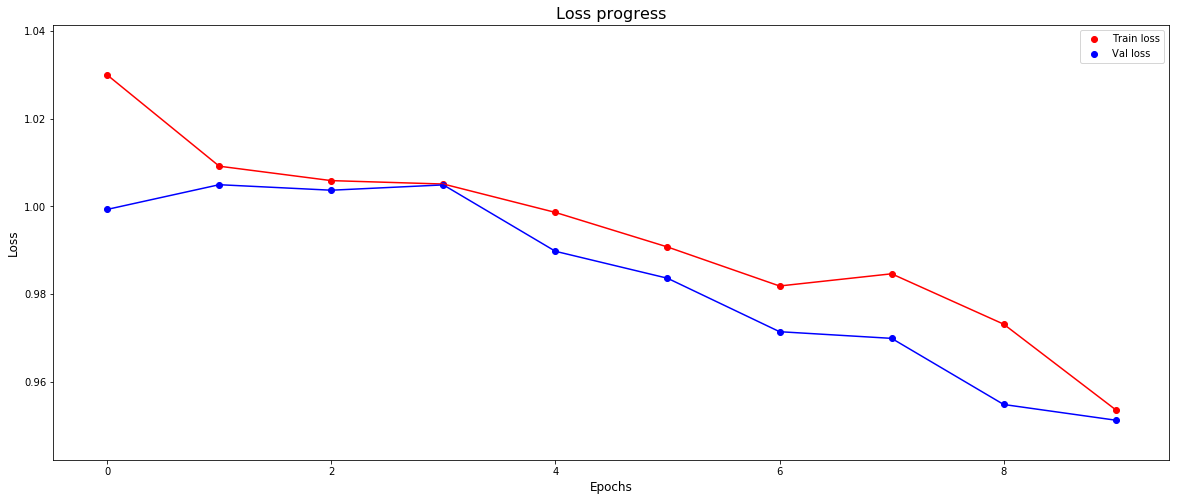

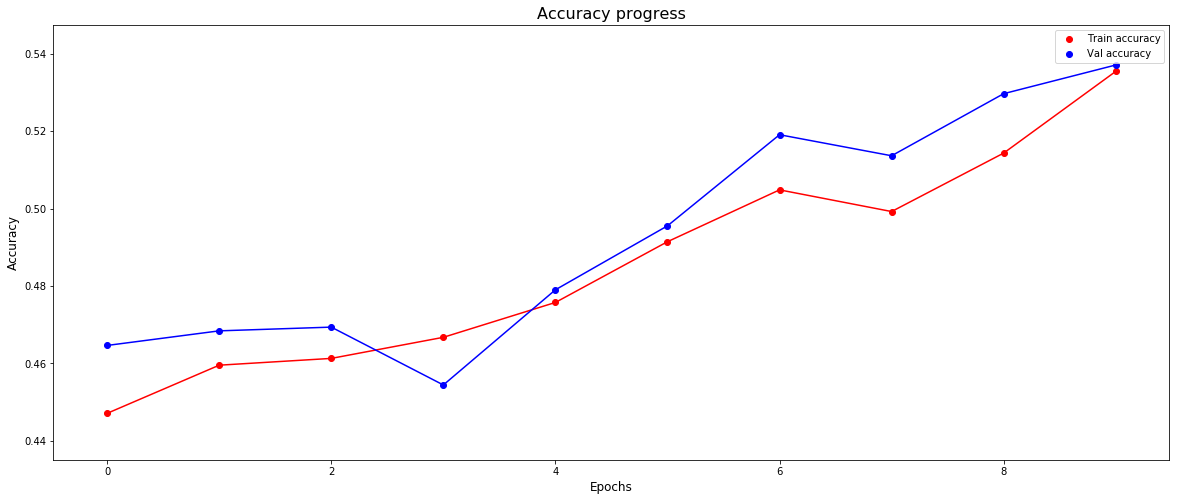

Training round: 1 with 5 epochs
	Epoch 0, Loss Train-Val: 0.937711 - 0.926452, Accuracy Train-Val: 0.937711 - 0.548582
	Epoch 1, Loss Train-Val: 0.925738 - 0.922578, Accuracy Train-Val: 0.925738 - 0.556955
	Epoch 2, Loss Train-Val: 0.897298 - 0.895358, Accuracy Train-Val: 0.897298 - 0.576133
	Epoch 3, Loss Train-Val: 0.878138 - 0.883675, Accuracy Train-Val: 0.878138 - 0.591542
	Epoch 4, Loss Train-Val: 0.864162 - 0.865549, Accuracy Train-Val: 0.864162 - 0.600484


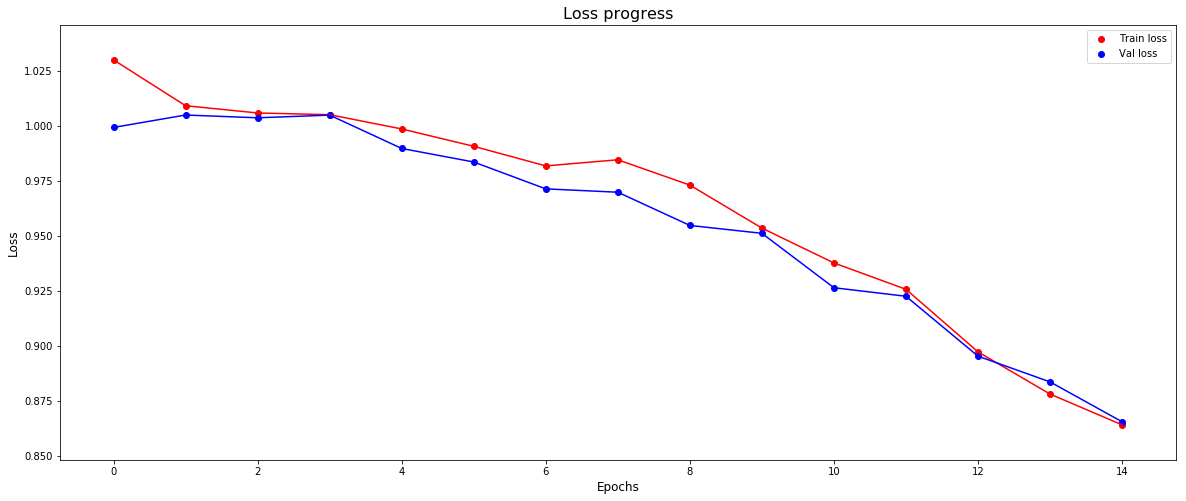

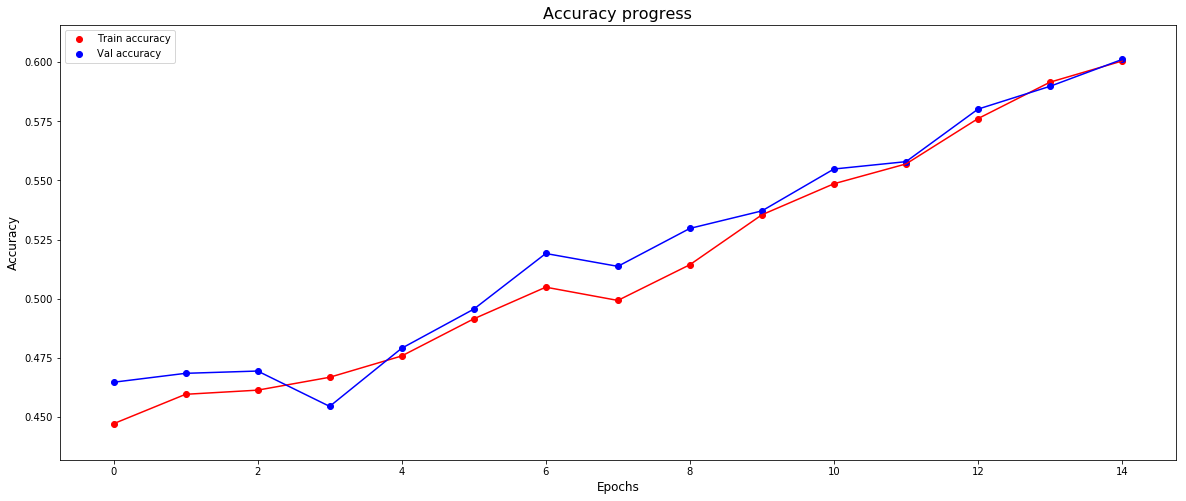

Training round: 2 with 5 epochs
	Epoch 0, Loss Train-Val: 0.834502 - 0.860348, Accuracy Train-Val: 0.834502 - 0.620342
	Epoch 1, Loss Train-Val: 0.807968 - 0.839902, Accuracy Train-Val: 0.807968 - 0.634162
	Epoch 2, Loss Train-Val: 0.796472 - 0.832586, Accuracy Train-Val: 0.796472 - 0.641263
	Epoch 3, Loss Train-Val: 0.769826 - 0.808116, Accuracy Train-Val: 0.769826 - 0.657516
	Epoch 4, Loss Train-Val: 0.741697 - 0.788358, Accuracy Train-Val: 0.741697 - 0.670097


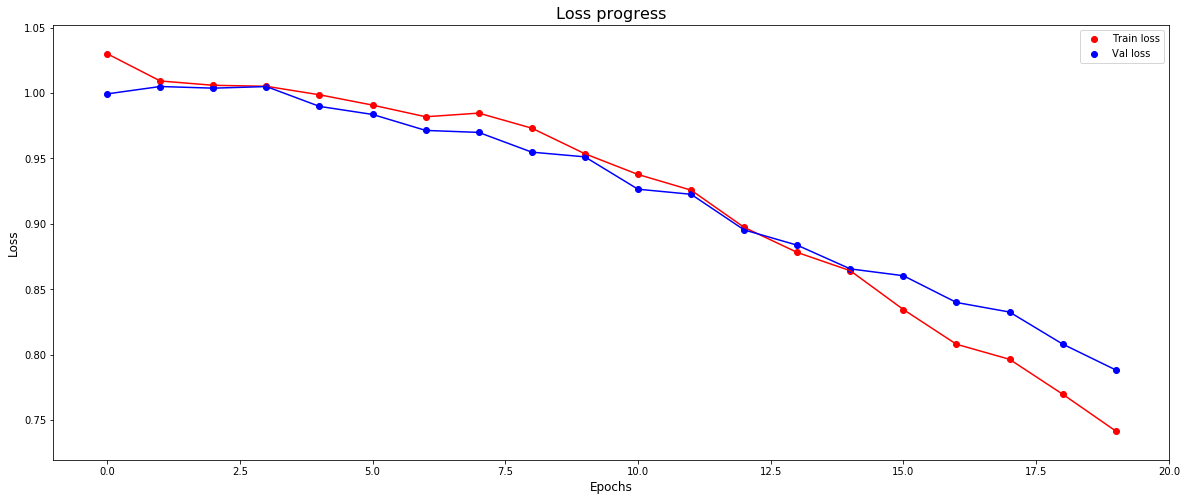

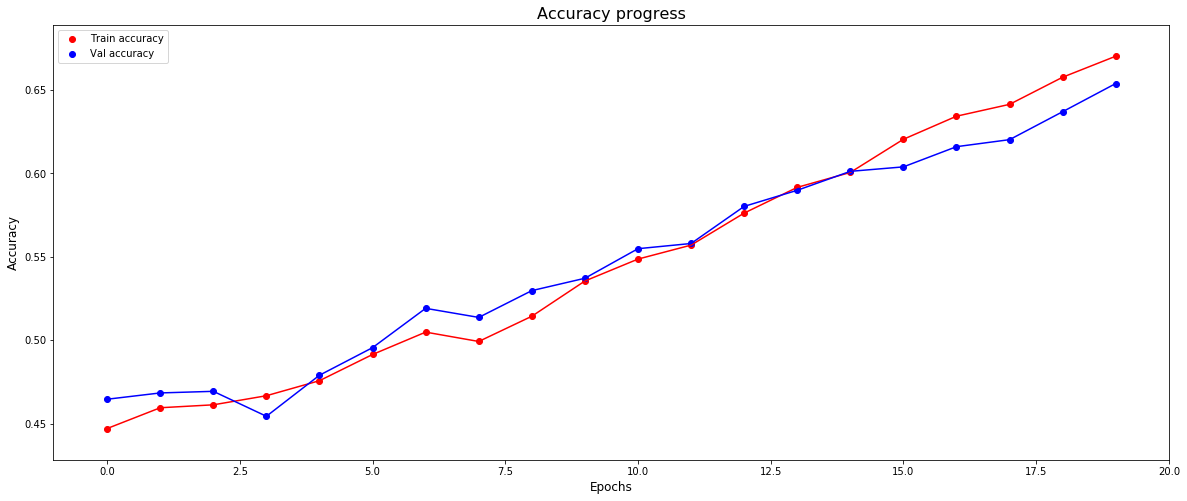

Training done
Predicting...
Train set - Loss: 0.669, Accuracy: 71.4295%
Test set - Loss: 0.7884, Accuracy: 65.3737%


In [7]:
# Train model
EPOCH_ROUNDS = [10, 5, 5] # Rounds of epochs to be used, change to something like this [10, 10, 5, 5] for better training
model = train_and_eval_model(X_train, X_test, Y_train, Y_test, WINDOW_SIZE, FORWARD_DAYS, LABELS, create_conv1D_model,
                             EPOCH_ROUNDS, log_steps=1, load_weights=False)